# Sparse Gaussian Process Regression

In this notebook we consider sparse Gaussian process regression (SGPR)
<strong data-cite="titsias2009">Titsias (2009)</strong>. This is a solution for
medium to large-scale conjugate regression problems.
In order to arrive at a computationally tractable method, the approximate posterior
is parameterized via a set of $m$ pseudo-points $\boldsymbol{z}$. Critically, the
approach leads to $\mathcal{O}(nm^2)$ complexity for approximate maximum likelihood
learning and $O(m^2)$ per test point for prediction.

In [18]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import matplotlib as mpl
import optax as ox
from jax import jit
from jax.config import config
from utils import clean_legend

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
plt.style.use('./gpjax.mplstyle')
cols = mpl.rcParams['axes.prop_cycle'].by_key()['color']

## Dataset

With the necessary modules imported, we simulate a dataset
$\mathcal{D} = (\boldsymbol{x}, \boldsymbol{y}) = \{(x_i, y_i)\}_{i=1}^{500}$
with inputs $\boldsymbol{x}$ sampled uniformly on $(-3., 3)$ and corresponding
independent noisy outputs

$$\boldsymbol{y} \sim \mathcal{N} \left(\sin(7\boldsymbol{x}) + x \cos(2 \boldsymbol{x}), \textbf{I} * 0.5^2 \right).$$

We store our data $\mathcal{D}$ as a GPJax `Dataset` and create test inputs and
labels for later.

In [19]:
n = 2500
noise = 0.5

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(2 * x) + x * jnp.cos(5 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.1, 3.1, 500).reshape(-1, 1)
ytest = f(xtest)

To better understand what we have simulated, we plot both the underlying latent
function and the observed data that is subject to Gaussian noise. We also plot an
initial set of inducing points over the space.

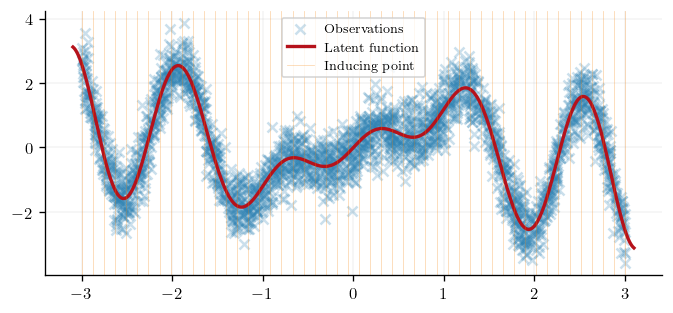

In [21]:
n_inducing = 50
z = jnp.linspace(-3.0, 3.0, n_inducing).reshape(-1, 1)

fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.25, label="Observations", color=cols[0])
ax.plot(xtest, ytest, label="Latent function",  linewidth=2, color=cols[1])
[ax.axvline(x=z_i, alpha=0.3, linewidth=0.5, label='Inducing point', color=cols[2]) for z_i in z]
ax.legend(loc="best")
ax = clean_legend(ax)
plt.show()

Next we define the true posterior model for the data - note that whilst we can define
this, it is intractable to evaluate.

In [22]:
meanf = gpx.Constant()
kernel = gpx.RBF()
likelihood = gpx.Gaussian(num_datapoints=D.n)
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
posterior = prior * likelihood

We now define the SGPR model through `CollapsedVariationalGaussian`. Through a
set of inducing points $\boldsymbol{z}$ this object builds an approximation to the
true posterior distribution. Consequently, we pass the true posterior and initial
inducing points into the constructor as arguments.

In [23]:
q = gpx.CollapsedVariationalGaussian(posterior=posterior, inducing_inputs=z)

We define our variational inference algorithm through `CollapsedVI`. This defines
the collapsed variational free energy bound considered in
<strong data-cite="titsias2009">Titsias (2009)</strong>.

In [24]:
elbo = jit(gpx.CollapsedELBO(negative=True))

We now train our model akin to a Gaussian process regression model via the `fit`
abstraction. Unlike the regression example given in the
[conjugate regression notebook](https://gpjax.readthedocs.io/en/latest/nbs/regression.html),
the inducing locations that induce our variational posterior distribution are now
part of the model's parameters. Using a gradient-based optimiser, we can then
_optimise_ their location such that the evidence lower bound is maximised.

In [25]:
opt_posterior, history = gpx.fit(
    model=q,
    objective=elbo,
    train_data=D,
    optim=ox.adamw(learning_rate=1e-2),
    num_iters=500,
)

/Users/tompinder/Development/JaxGPDevs/GPJax/gpjax/fit.py:190: UserWarning: Objective is jit-compiled. Please ensure that the objective is of type gpjax.Objective.
  warn("Objective is jit-compiled. Please ensure that the objective is of type gpjax.Objective.")


  0%|          | 0/500 [00:00<?, ?it/s]

[Text(0.5, 0, 'Training iterate'), Text(0, 0.5, 'ELBO')]

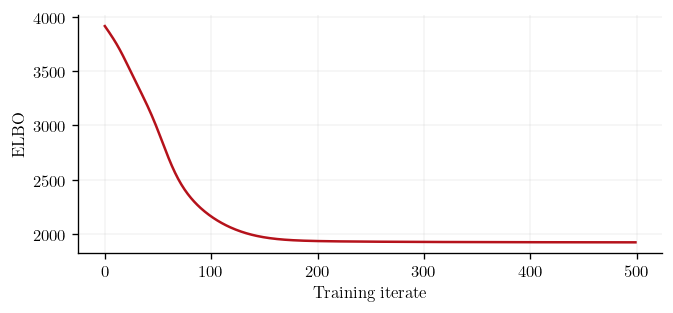

In [26]:
fig, ax = plt.subplots()
ax.plot(history, color=cols[1])
ax.set(xlabel = 'Training iterate', ylabel = 'ELBO')

We show predictions of our model with the learned inducing points overlayed in grey.

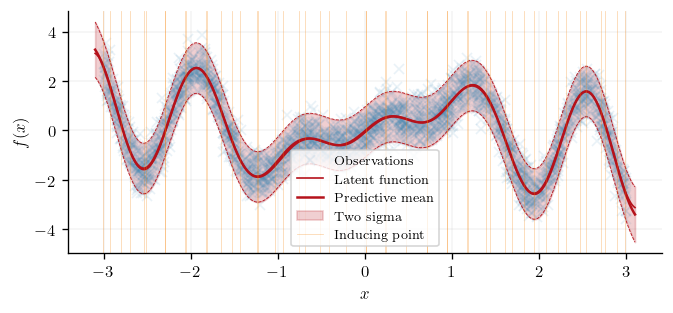

In [27]:
latent_dist = opt_posterior(xtest, train_data=D)
predictive_dist = opt_posterior.posterior.likelihood(latent_dist)

inducing_points = opt_posterior.inducing_inputs

samples = latent_dist.sample(seed=key, sample_shape=(20,))

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

fig, ax = plt.subplots()

ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.1)
ax.plot(
    xtest,
    ytest,
    label="Latent function",
    color=cols[1],
    linestyle="-",
    linewidth=1,
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])

ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2*predictive_std,
    predictive_mean + 2*predictive_std,
    alpha=0.2,
    color=cols[1],
    label="Two sigma",
)
ax.plot(
    xtest,
    predictive_mean - 2*predictive_std,
    color=cols[1],
    linestyle="--",
    linewidth=0.5,
)
ax.plot(
    xtest,
    predictive_mean + 2*predictive_std,
    color=cols[1],
    linestyle="--",
    linewidth=0.5,
)

[ax.axvline(x=z_i, alpha=0.3, linewidth=0.5, label='Inducing point', color=cols[2]) for z_i in inducing_points]
ax.legend()
ax = clean_legend(ax)
ax.set(xlabel=r'$x$', ylabel=r'$f(x)$')
plt.show()

## Runtime comparison

Given the size of the data being considered here, inference in a GP with a full-rank
covariance matrix is possible, albeit quite slow. We can therefore compare the
speedup that we get from using the above sparse approximation with corresponding
bound on the marginal log-likelihood against the marginal log-likelihood in the
full model.

In [ ]:
full_rank_model = gpx.Prior(mean_function=gpx.Zero(), kernel=gpx.RBF()) * gpx.Gaussian(
    num_datapoints=D.n
)
negative_mll = jit(gpx.ConjugateMLL(negative=True))
%timeit negative_mll(full_rank_model, D).block_until_ready()

The slowest run took 4.11 times longer than the fastest. This could mean that an intermediate result is being cached.
397 ms ± 221 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
negative_elbo = jit(gpx.CollapsedELBO(negative=True))
%timeit negative_elbo(q, D).block_until_ready()

5.98 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As we can see, the sparse approximation given here is around 50 times faster when
compared against a full-rank model.

## System configuration

In [ ]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Daniel Dodd'

Author: Daniel Dodd

Last updated: Fri Apr 21 2023

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.11.0

gpjax     : 0.5.9.post47.dev0+4f510ee
jax       : 0.4.8
optax     : 0.1.4
matplotlib: 3.7.1

Watermark: 2.3.1

